# Chapter 4.4-4.5: Construct Descriptives and Preferences

This notebook generates the main descriptive results used in:
- **Section 4.4**: Construct scores (Means & SDs) for **Fairness, Transparency, Trust, Willingness to Apply**
- **Section 4.4.1-4.4.3**: Item-level indicators for key statements (agreement patterns)
- **Section 4.5**: Recruitment process preferences (hybrid vs human-only vs AI-dominant) and screening comfort

**Input:** `data.csv` (Google Forms export)  
**Output:** Summary tables and bar charts for construct results and preference distributions.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display

df = pd.read_csv("data.csv") #reads data from the same repository
N = len(df) 

In [2]:
# 1) Helpers: find columns, Likert coding, reverse-coding

def find_col_contains(df, needle: str):
    """Find the first column name containing the given substring."""
    for c in df.columns:
        if needle in c:
            return c
    return None

LIKERT_MAP = {
    'strongly disagree': 1,
    'disagree': 2,
    'neither agree nor disagree': 3,
    'agree': 4,
    'strongly agree': 5,
}

def to_likert_numeric(series: pd.Series) -> pd.Series:
    """Convert Likert text to numeric 1–5, preserving NaN."""
    s = series.astype(str).str.strip().str.lower()
    # keep NaNs as NaN
    s = s.replace({'nan': np.nan})
    return s.map(LIKERT_MAP)

def reverse_code(series_num: pd.Series) -> pd.Series:
    """Reverse code a 1–5 Likert numeric series."""
    return series_num.apply(lambda x: 6 - x if pd.notna(x) else np.nan)

def agree_strongly_pct(series_text: pd.Series, N_total: int):
    """Percent who answered Agree/Strongly agree in a Likert text column."""
    s = series_text.astype(str).str.strip().str.lower()
    s = s.replace({'nan': np.nan})
    n = int(s.isin(['agree', 'strongly agree']).sum())
    return n, round(n / N_total * 100, 1)

def likely_pct(series_num: pd.Series, N_total: int, threshold: int = 4):
    """For 1–5 numeric scales, percent selecting >= threshold (e.g., likely/very likely)."""
    s = pd.to_numeric(series_num, errors='coerce')
    n = int((s >= threshold).sum())
    return n, round(n / N_total * 100, 1)

def freq_table(series, N_total=None):
    counts = series.value_counts(dropna=False)
    denom = N_total if N_total is not None else counts.sum()
    return pd.DataFrame({
        'Category': counts.index.astype(str),
        'n': counts.values,
        '%': (counts.values / denom * 100).round(1)
    })


In [3]:
# 2) Identify key columns (by searching for statement text)


# Likert statements (text columns)
col_same_criteria = find_col_contains(df, '[AI-based recruitment treats all candidates according to the same criteria.]')
col_reduce_bias = find_col_contains(df, '[Using AI in recruitment can help reduce human bias in hiring decisions.]')
col_inherently_unfair = find_col_contains(df, '[AI-based recruitment systems are inherently unfair.')

col_understand_eval = find_col_contains(df, '[I understand, at least in general terms, how AI recruitment systems evaluate candidates.]')
col_companies_explain = find_col_contains(df, '[Companies clearly explain when and how they use AI in their recruitment process.]')
col_black_box = find_col_contains(df, '[AI-based recruitment systems feel like a “black box” to me.')

col_trust_fair = find_col_contains(df, '[I trust AI systems to evaluate candidates fairly.]')
col_worry_discriminate = find_col_contains(df, '[I worry that AI recruitment systems might discriminate against certain groups of applicants.')
col_uncomfortable_final = find_col_contains(df, '[I would be uncomfortable if an AI system made the final decision about whether I get an interview.')

col_overall_positive = find_col_contains(df, '[Overall, I feel positive about the use of AI in recruitment.]')
col_would_apply = find_col_contains(df, '[I would apply to a company that uses AI in its recruitment process.]')
col_discourage_apply = find_col_contains(df, '[Knowing that a company uses AI to screen applications would discourage me from applying.')

# Numeric 1–5
col_likely_apply_if_disclosed = 'If a company clearly states that it uses AI tools as part of its recruitment process, how likely would you be to apply for a job or internship there?'

# Preferences (categorical)
col_recruitment_preference = 'If you had two similar job opportunities, and the only difference was the recruitment process, which would you prefer?'
col_screening_comfort = 'For the initial screening of applications (deciding who is invited to the first interview), which option would you feel most comfortable with?'

cols_found = {
    'same_criteria': col_same_criteria,
    'reduce_bias': col_reduce_bias,
    'inherently_unfair (reverse)': col_inherently_unfair,
    'understand_eval': col_understand_eval,
    'companies_explain': col_companies_explain,
    'black_box (reverse for construct)': col_black_box,
    'trust_fair': col_trust_fair,
    'worry_discriminate (reverse)': col_worry_discriminate,
    'uncomfortable_final (reverse)': col_uncomfortable_final,
    'overall_positive': col_overall_positive,
    'would_apply': col_would_apply,
    'discourage_apply (reverse)': col_discourage_apply,
}

print('Missing columns (if any):')
missing = [k for k,v in cols_found.items() if v is None]
missing

Missing columns (if any):


[]

In [4]:
# 3) Recode Likert items to numeric, apply reverse-coding where needed

num = pd.DataFrame(index=df.index)

# Fairness items
num['fair_same_criteria'] = to_likert_numeric(df[col_same_criteria])
num['fair_reduce_bias'] = to_likert_numeric(df[col_reduce_bias])
num['fair_inherently_unfair_rev'] = reverse_code(to_likert_numeric(df[col_inherently_unfair]))

# Transparency items
num['trans_understand_eval'] = to_likert_numeric(df[col_understand_eval])
num['trans_companies_explain'] = to_likert_numeric(df[col_companies_explain])
num['trans_black_box_rev'] = reverse_code(to_likert_numeric(df[col_black_box]))

# Trust items
num['trust_fair_eval'] = to_likert_numeric(df[col_trust_fair])
num['trust_worry_discriminate_rev'] = reverse_code(to_likert_numeric(df[col_worry_discriminate]))
num['trust_uncomfortable_final_rev'] = reverse_code(to_likert_numeric(df[col_uncomfortable_final]))

# Willingness to apply (behavioral intention)
num['apply_would_apply'] = to_likert_numeric(df[col_would_apply])
num['apply_discourage_rev'] = reverse_code(to_likert_numeric(df[col_discourage_apply]))
num['apply_likely_if_disclosed'] = pd.to_numeric(df[col_likely_apply_if_disclosed], errors='coerce')

num.head()

,fair_same_criteria,fair_reduce_bias,fair_inherently_unfair_rev,trans_understand_eval,trans_companies_explain,trans_black_box_rev,trust_fair_eval,trust_worry_discriminate_rev,trust_uncomfortable_final_rev,apply_would_apply,apply_discourage_rev,apply_likely_if_disclosed
0,4,2,3,3,5,4,2,1,5,3,2,4
1,4,3,5,4,2,1,5,2,3,4,3,4
2,3,2,1,3,4,5,2,3,3,2,3,2
3,4,5,1,3,4,2,3,3,4,3,4,4
4,4,5,2,3,4,5,4,1,2,3,2,2


In [5]:
# 4) Construct scores (mean across items per respondent)

constructs = pd.DataFrame(index=df.index)

constructs['Fairness'] = num[['fair_same_criteria','fair_reduce_bias','fair_inherently_unfair_rev']].mean(axis=1)
constructs['Transparency'] = num[['trans_understand_eval','trans_companies_explain','trans_black_box_rev']].mean(axis=1)

# Trust: ONLY the two trust-relevant items
constructs['Trust'] = num[['trust_fair_eval','trust_worry_discriminate_rev']].mean(axis=1)

constructs['Willingness_to_apply'] = num[['apply_would_apply','apply_discourage_rev','apply_likely_if_disclosed']].mean(axis=1)

constructs.describe().T[['count','mean','std','min','max']]


,count,mean,std,min,max
Fairness,84.0,3.130952,0.720735,1.333333,5.000000
Transparency,84.0,2.857143,0.669243,1.666667,4.333333
Trust,84.0,2.821429,0.897261,1.000000,5.000000
Willingness_to_apply,84.0,3.015873,0.713054,1.333333,5.000000


## 4.4 Key Construct Results (Means & SDs)

Higher values (which are closer to 5) indicate more positive perceptions after reverse-coding negative items.


,N,Mean,SD
Fairness,84,3.13,0.72
Transparency,84,2.86,0.67
Trust,84,2.82,0.90
Willingness_to_apply,84,3.02,0.71


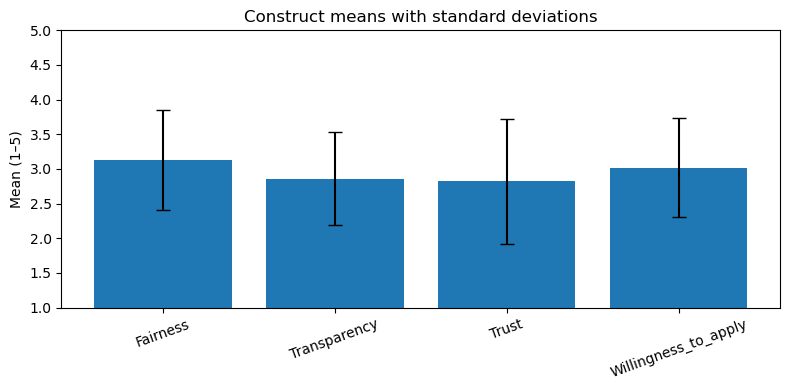

In [6]:
summary = pd.DataFrame({
    'N': constructs.notna().sum(),
    'Mean': constructs.mean().round(2),
    'SD': constructs.std().round(2)
})

display(summary)

# Simple bar chart of construct means (with SDs)
fig, ax = plt.subplots(figsize=(8,4))
ax.bar(summary.index, summary['Mean'], yerr=summary['SD'], capsize=5)
ax.set_title('Construct means with standard deviations')
ax.set_ylabel('Mean (1–5)')
ax.set_ylim(1, 5)
ax.tick_params(axis='x', rotation=20)
plt.tight_layout()
plt.show()

### 4.4.1 Perceived Fairness: Item-level indicators


In [7]:
fair_items = pd.DataFrame({
    'Item': [
        'AI uses the same criteria for all candidates',
        'AI reduces human bias in hiring decisions',
        'AI-based recruitment systems are inherently unfair (reverse-coded)'
    ],
    'Mean': [
        num['fair_same_criteria'].mean(),
        num['fair_reduce_bias'].mean(),
        (6 - to_likert_numeric(df[col_inherently_unfair])).mean()  
    ],
    'SD': [
        num['fair_same_criteria'].std(),
        num['fair_reduce_bias'].std(),
        (6 - to_likert_numeric(df[col_inherently_unfair])).std()
    ]
}).round(2)

display(fair_items)

,Item,Mean,SD
0,AI uses the same criteria for all candidates,3.56,1.15
1,AI reduces human bias in hiring decisions,3.32,1.19
2,AI-based recruitment systems are inherently un...,2.51,1.16


### 4.4.2 Perceived Transparency: Key frequency indicators


,Indicator,n,%
0,AI recruitment systems feel like a black box (...,52,61.9
1,Companies clearly explain when/how they use AI...,21,25.0


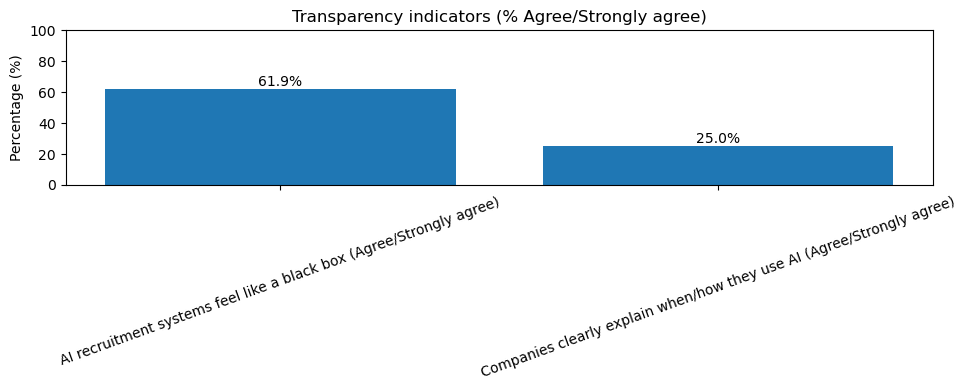

In [8]:
# % Agree/Strongly agree that systems feel like a black box (original statement direction)
n_black, pct_black = agree_strongly_pct(df[col_black_box], N)

# % Agree/Strongly agree that companies clearly explain AI use
n_explain, pct_explain = agree_strongly_pct(df[col_companies_explain], N)

trans_freq = pd.DataFrame([
    {'Indicator': 'AI recruitment systems feel like a black box (Agree/Strongly agree)', 'n': n_black, '%': pct_black},
    {'Indicator': 'Companies clearly explain when/how they use AI (Agree/Strongly agree)', 'n': n_explain, '%': pct_explain},
])

display(trans_freq)

# Bar chart
fig, ax = plt.subplots(figsize=(10,4))
ax.bar(trans_freq['Indicator'], trans_freq['%'])
ax.set_title('Transparency indicators (% Agree/Strongly agree)')
ax.set_ylabel('Percentage (%)')
ax.set_ylim(0, 100)
ax.tick_params(axis='x', rotation=20)
for i, v in enumerate(trans_freq['%']):
    ax.annotate(f"{v}%", (i, v), ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

### 4.4.3 Trust in AI Recruitment: Key frequency indicator


,Indicator,n,%
0,Worry AI may discriminate against some groups ...,50,59.5


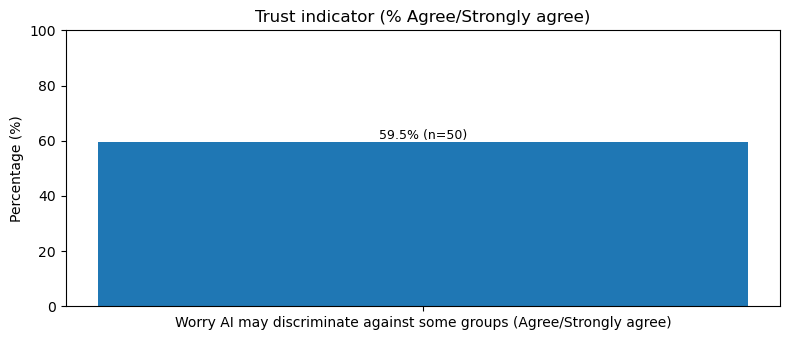

In [9]:
n_disc, pct_disc = agree_strongly_pct(df[col_worry_discriminate], N)

trust_freq = pd.DataFrame([
    {'Indicator': 'Worry AI may discriminate against some groups (Agree/Strongly agree)', 'n': n_disc, '%': pct_disc},
])
display(trust_freq)

fig, ax = plt.subplots(figsize=(8,3.5))
ax.bar(trust_freq['Indicator'], trust_freq['%'])
ax.set_title('Trust indicator (% Agree/Strongly agree)')
ax.set_ylabel('Percentage (%)')
ax.set_ylim(0, 100)
ax.tick_params(axis='x', rotation=0)
ax.annotate(f"{pct_disc}% (n={n_disc})", (0, pct_disc), ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

## 4.5 Preferences in Willingness to Apply and Recruitment Model


,Indicator,n,%
0,Would apply to a company using AI (Agree/Stron...,22,26.2
1,Knowing AI is used would discourage me (Agree/...,34,40.5
2,Likely/Very likely to apply if AI use is clear...,41,48.8


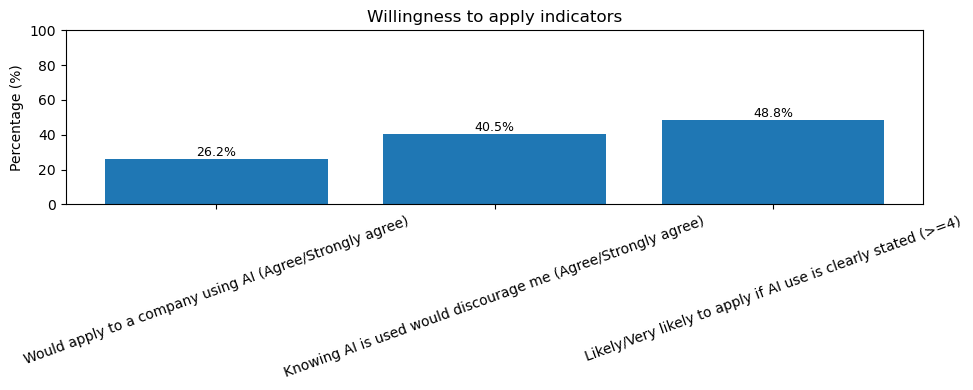

In [10]:
# 4.5.1 Willingness indicators (Agree/Strongly agree)
n_apply, pct_apply = agree_strongly_pct(df[col_would_apply], N)
n_discourage, pct_discourage = agree_strongly_pct(df[col_discourage_apply], N)
n_likely, pct_likely = likely_pct(df[col_likely_apply_if_disclosed], N, threshold=4)

willingness_freq = pd.DataFrame([
    {'Indicator': 'Would apply to a company using AI (Agree/Strongly agree)', 'n': n_apply, '%': pct_apply},
    {'Indicator': 'Knowing AI is used would discourage me (Agree/Strongly agree)', 'n': n_discourage, '%': pct_discourage},
    {'Indicator': 'Likely/Very likely to apply if AI use is clearly stated (>=4)', 'n': n_likely, '%': pct_likely},
])
display(willingness_freq)

fig, ax = plt.subplots(figsize=(10,4))
ax.bar(willingness_freq['Indicator'], willingness_freq['%'])
ax.set_title('Willingness to apply indicators')
ax.set_ylabel('Percentage (%)')
ax.set_ylim(0, 100)
ax.tick_params(axis='x', rotation=20)
for i, v in enumerate(willingness_freq['%']):
    ax.annotate(f"{v}%", (i, v), ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

,Category,n,%
0,Company B: Recruitment handled by a combinatio...,39,46.4
1,Company A: Recruitment handled mainly by human...,25,29.8
2,I have no preference / I don’t know,16,19.0
3,Company C: Recruitment handled mainly by AI to...,4,4.8


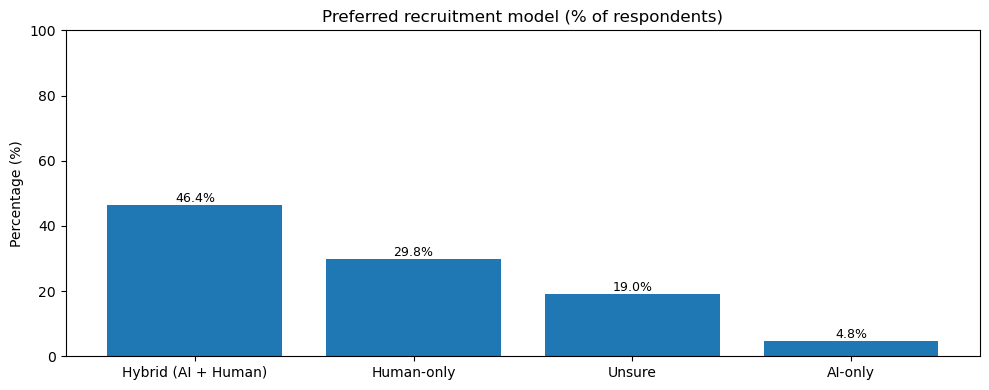

In [11]:
# 4.5.2 Recruitment model preferences (distribution)
pref_tbl = freq_table(df[col_recruitment_preference], N_total=N)
display(pref_tbl)

labels = ["Hybrid (AI + Human)", "Human-only", "Unsure", "AI-only"]  # Shortening labels for figure (labels must match the number and order of bars)

fig, ax = plt.subplots(figsize=(10,4))
ax.bar(range(len(pref_tbl)), pref_tbl["%"])
ax.set_xticks(range(len(pref_tbl)))
ax.set_xticklabels(labels, rotation=90)
ax.set_title('Preferred recruitment model (% of respondents)')
ax.set_ylabel('Percentage (%)')
ax.set_ylim(0, 100)
ax.tick_params(axis='x', rotation=0)
for i, v in enumerate(pref_tbl['%']):
    ax.annotate(f"{v}%", (i, v), ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

,Category,n,%
0,"AI tools review applications first, and human ...",44,52.4
1,Only human recruiters review all applications,24,28.6
2,I have no preference / I don’t know,10,11.9
3,AI tools fully decide which candidates are sho...,6,7.1


C:\Users\SALMAN\AppData\Local\Temp\ipykernel_18708\12387997.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)


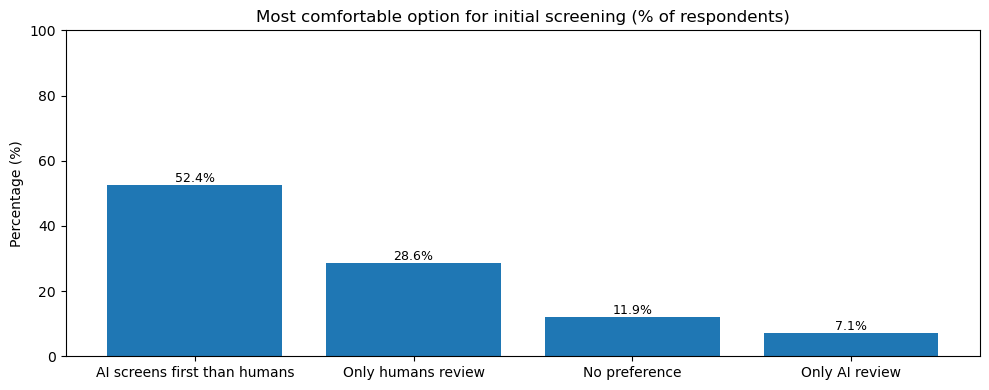

AI-first then human shortlisting (best-effort match): 44 (52.4%)


In [12]:
# Initial screening comfort (distribution)
screen_tbl = freq_table(df[col_screening_comfort], N_total=N)
display(screen_tbl)

labels = ["AI screens first than humans", "Only humans review", "No preference", "Only AI review"]

fig, ax = plt.subplots(figsize=(10,4))
ax.bar(screen_tbl['Category'], screen_tbl['%'])
ax.set_title('Most comfortable option for initial screening (% of respondents)')
ax.set_xticklabels(labels, rotation=90)
ax.set_ylabel('Percentage (%)')
ax.set_ylim(0, 100)
ax.tick_params(axis='x', rotation=0)
for i, v in enumerate(screen_tbl['%']):
    ax.annotate(f"{v}%", (i, v), ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

# Also extract the % for the option that looks like "AI first, then human shortlisting" (best-effort match)
ai_then_human_mask = df[col_screening_comfort].astype(str).str.lower().str.contains('ai') & df[col_screening_comfort].astype(str).str.lower().str.contains('human')
n_ai_then_human = int(ai_then_human_mask.sum())
pct_ai_then_human = round(n_ai_then_human / N * 100, 1)
print(f"AI-first then human shortlisting (best-effort match): {n_ai_then_human} ({pct_ai_then_human}%)")